# Regressione lineare con Iris (da CSV)

Notebook per una lezione di ~4 ore (studenti junior)

Questa lezione usa il dataset **Iris** (molto famoso) per spiegare la **regressione** in modo controllato.

- Nel dataset Iris la variabile `species` e' una classe (quindi e' tipica della classificazione).
- Qui invece useremo solo le colonne **numeriche** per predire una variabile continua (es. `petal_length`).

Idea chiave: la regressione cerca una formula che collega input e output.


## Obiettivi della lezione
- Capire l’idea di **regressione**: prevedere un numero (variabile continua)
- Caricare e ispezionare un dataset da `iris.csv`
- Costruire un modello di **regressione lineare** con scikit-learn
- Valutare il modello con metriche e grafici (errori, residui)
- Estendere a **regressione multipla** e, opzionale, **polinomiale**

## Prerequisiti
- Python installato
- VS Code + estensione Jupyter
- File `iris.csv` nella stessa cartella del notebook (oppure aggiorna il path)

## Agenda (indicativa)
1. Caricamento dati e controlli (30–40 min)
2. Esplorazione dati con grafici (50–60 min)
3. Regressione lineare semplice: train/test, metriche, grafici (60–70 min)
4. Regressione multipla: interpretazione coefficienti, confronto (40–50 min)
5. Estensioni e mini-esercizi (30–40 min)

A fine lezione devi saper fare (e spiegare):

1. Cos'e' una regressione lineare e quando ha senso usarla.
2. Come si prepara la coppia **X (feature)** e **y (target)**.
3. Perche' si fa la divisione **train/test**.
4. Come si allena un modello con scikit-learn (`fit`) e come si fanno predizioni (`predict`).
5. Come si interpretano le metriche **MAE**, **RMSE**, **R^2**.
6. Come confrontare modelli diversi (semplice vs multiplo) in modo onesto.

Nota per junior: sapere eseguire il codice non basta. Devi capire cosa rappresentano i numeri e i grafici.


## 1) Setup e import
Esegui questa cella per importare librerie e impostare alcune opzioni grafiche.

In questa sezione importiamo:

- librerie per gestire numeri e tabelle (`numpy`, `pandas`)
- librerie per grafici (`matplotlib`, `seaborn`)
- funzioni scikit-learn per:
  - dividere i dati (train/test)
  - creare il modello di regressione
  - calcolare metriche di errore

Se un import fallisce, di solito mancano pacchetti nell'ambiente virtuale.


In [6]:
# NOTE DIDATTICA
# Import: librerie per tabelle (pandas), numeri (numpy) e grafici (matplotlib/seaborn).
# Scikit-learn: usato per split, modello di regressione e metriche.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Per rendere i grafici più leggibili
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

print("Setup OK")

Setup OK


## 2) Carica `iris.csv`

Metti `iris.csv` **nella stessa cartella** di questo notebook.
Se il file è altrove, modifica `csv_path`.

Nota: Iris nasce come dataset di **classificazione** (specie). Qui lo usiamo per una **regressione**: prevediamo una misura (es. `petal_length`) da altre misure.

Carichiamo il dataset da CSV.

Punto importante (spesso confonde):
- **Il CSV e' solo un file di dati**.
- Il modello non "legge" il CSV: noi lo trasformiamo in una tabella `pandas.DataFrame`.

Consiglio pratico: appena carichi un dataset, controlla subito:
- prime righe (`head`)
- nomi colonne
- tipi delle colonne
- valori mancanti


In [7]:
# NOTE DIDATTICA
# Carichiamo il dataset.
# Se hai gia' /data/iris.csv, assicurati che il path in read_csv punti a quello.
# Obiettivo: ottenere un DataFrame df con colonne numeriche + 'species'.

# Dataset
# Opzione A: se hai un file locale "iris.csv" nella stessa cartella del notebook, verrà usato quello.
# Opzione B: se il file non c'è, carichiamo Iris direttamente da scikit-learn (notebook autosufficiente)

from pathlib import Path
from sklearn.datasets import load_iris

csv_path = Path("data/iris.csv")  # cambia qui se necessario

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f"Letto dataset da file: {csv_path.resolve()}")
else:
    iris = load_iris(as_frame=True)
    df = iris.frame.copy()  # include anche la colonna 'target'
    # Aggiungiamo anche la specie in chiaro (utile per eventuali esempi)
    df["species"] = df["target"].map(dict(enumerate(iris.target_names)))
    # Manteniamo solo le feature + species (per questa lezione la specie non serve alla regressione, ma non dà fastidio)
    df = df.drop(columns=["target"])
    print("iris.csv non trovato: caricato Iris da scikit-learn")
    # Facoltativo: salva un csv per riusarlo offline
    df.to_csv(csv_path, index=False)
    print(f"Salvato anche un file locale: {csv_path.resolve()}")

df.head()

Letto dataset da file: /home/marco/projects/PythonEx/src/Modulo 4/data/iris.csv


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Controllo rapido: colonne, tipi, valori mancanti

Questa cella serve a evitare errori piu' avanti.

- `df.info()` dice quante righe/colonne ci sono e i tipi (`float`, `object`, ecc.)
- `df.describe()` riassume statistiche (min, max, media...) sulle colonne numeriche

Se trovi valori mancanti (`NaN`) o tipi strani (numeri letti come testo), devi sistemare prima di allenare.


In [8]:
# NOTE DIDATTICA
# Primo controllo di sanita': dimensioni, tipi e statistiche.
# Se qui vedi NaN o colonne numeriche lette come testo, sistemale prima di proseguire.

display(df.info())
display(df.describe(include="all"))

missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


None

,sepal_length,sepal_width,petal_length,petal_width,species
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.054000,3.758667,1.198667,NaN
std,0.828066,0.433594,1.764420,0.763161,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


Series([], dtype: int64)

## 3) Pulizia minima e standardizzazione nomi colonne

Dataset Iris da CSV spesso ha nomi tipo `sepal_length`, oppure `SepalLengthCm`. Normalizziamo i nomi e facciamo una scelta chiara.

Se il tuo CSV ha già nomi puliti, questa cella non fa danni (rinomina solo quando serve).

Standardizziamo i nomi delle colonne per evitare problemi di battitura.

Esempio: `Sepal Length` e `sepal_length` sono la stessa cosa concettualmente, ma per Python sono stringhe diverse.

Regola pratica: usa sempre nomi semplici, minuscoli, senza spazi.


In [9]:
# NOTE DIDATTICA
# Normalizziamo i nomi delle colonne per poterle richiamare senza errori di battitura.

# Normalizza nomi: minuscolo, spazi->underscore
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Rinomine comuni (se presenti)
rename_map = {
    "sepallengthcm": "sepal_length",
    "sepalwidthcm": "sepal_width",
    "petallengthcm": "petal_length",
    "petalwidthcm": "petal_width",
    "sepal_length_(cm)": "sepal_length",
    "sepal_width_(cm)": "sepal_width",
    "petal_length_(cm)": "petal_length",
    "petal_width_(cm)": "petal_width",
    "species": "species"
}
df = df.rename(columns={c: rename_map[c] for c in df.columns if c in rename_map})

df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

## 4) Esplorazione dati (EDA) con grafici

Qui facciamo grafici “belli” e immediati.

### 4.1 Distribuzioni (istogrammi)
Scegliamo le colonne numeriche e vediamo come sono distribuite.

Prima di allenare un modello, guardiamo i dati.

Perche'?
- la regressione lineare funziona meglio quando la relazione tra X e y e' "quasi" lineare
- se ci sono outlier o distribuzioni strane, le metriche possono peggiorare

In questa sezione facciamo EDA minima:
- istogrammi (distribuzioni)
- scatter (relazione tra due variabili)
- correlazioni (riassunto numerico della relazione lineare)


In [10]:
# NOTE DIDATTICA
# Selezioniamo solo le colonne numeriche: sono quelle su cui faremo regressione e grafici.

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

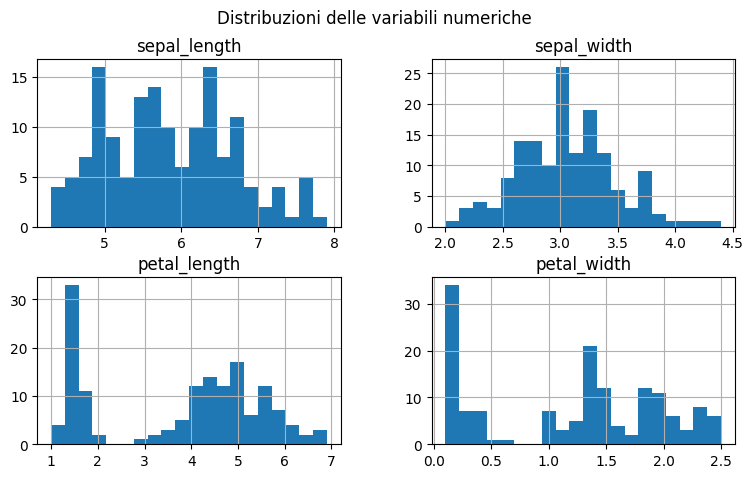

In [11]:
# NOTE DIDATTICA
# Istogrammi: ci fanno capire scala e distribuzione (es. valori concentrati, outlier).

df[num_cols].hist(bins=20)
plt.suptitle("Distribuzioni delle variabili numeriche")
plt.show()

### 4.2 Scatter plot: relazione tra due variabili

Per la regressione lineare semplice useremo:
- **X = sepal_length**
- **y = petal_length**

Motivo: c’è spesso una relazione abbastanza lineare e si vede bene a occhio.

Uno scatter plot mette:

- asse X: una variabile di input (feature)
- asse Y: una variabile che potremmo voler predire (target)

Cosa osservare:
- i punti seguono una direzione chiara? (sale o scende?)
- la nuvola e' stretta (buon segnale) o molto larga (relazione debole)?


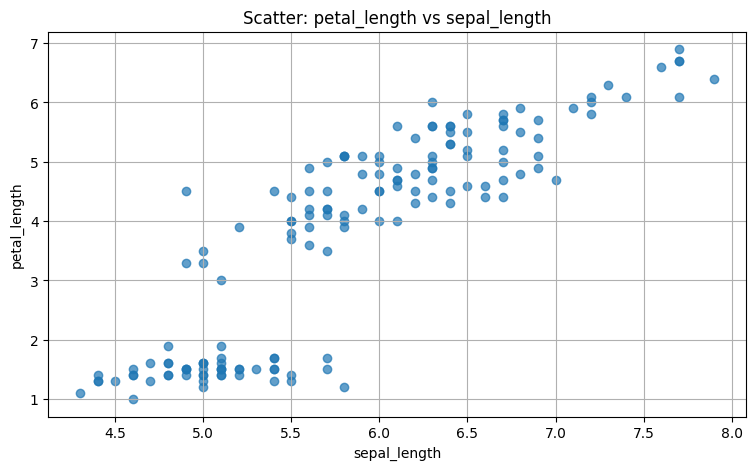

In [12]:
# NOTE DIDATTICA
# Qui scegliamo esplicitamente quale feature (x_col) usare e quale target (y_col) predire.
# Per junior: cambiare queste due righe cambia tutto l'esperimento.

x_col = "sepal_length"
y_col = "petal_length"

if x_col not in df.columns or y_col not in df.columns:
    raise ValueError(f"Colonne attese non trovate. Colonne disponibili: {list(df.columns)}")

plt.scatter(df[x_col], df[y_col], alpha=0.7)
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter: {y_col} vs {x_col}")
plt.show()

### 4.3 Correlazioni (heatmap semplice)

Non usiamo librerie extra: solo matplotlib.

La correlazione (Pearson) misura quanto due variabili sono legate in modo **lineare**.

- vicino a **+1**: relazione lineare crescente forte
- vicino a **-1**: relazione lineare decrescente forte
- vicino a **0**: relazione lineare debole o assente

Attenzione: correlazione alta non significa causalita'.


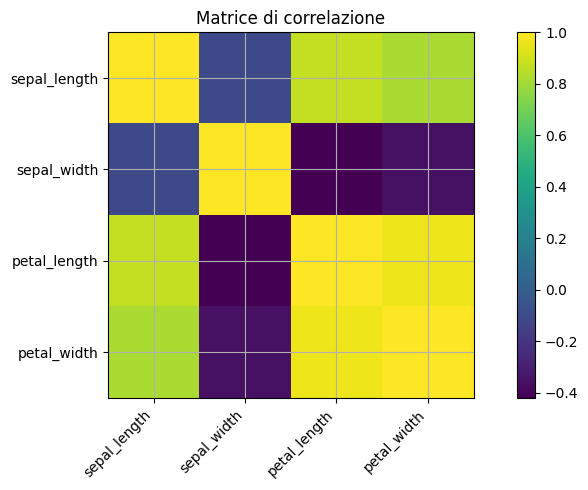

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


In [13]:
# NOTE DIDATTICA
# Matrice di correlazione: riassunto numerico della relazione lineare tra coppie di variabili.

corr = df[num_cols].corr(numeric_only=True)

plt.imshow(corr.values)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matrice di correlazione")
plt.tight_layout()
plt.show()

corr

## 5) Regressione lineare semplice (una X → una y)

### Idea in 20 secondi
Vogliamo trovare una **retta** del tipo:

y = a · x + b

che passi **il più vicino possibile ai punti** osservati.

- `a` è la **pendenza** (quanto cresce y quando x aumenta)
- `b` è il **valore di partenza** (il valore di y quando x = 0)

Il modello cercherà automaticamente i valori migliori di `a` e `b`.

### Definiamo X e y

Qui facciamo la regressione **più semplice possibile**:

- una sola feature **X** (una colonna di input)
- un solo target **y** (una colonna da predire)

L’obiettivo non è la performance, ma capire **il flusso standard** di una regressione:

1. definire X e y  
2. dividere i dati in train e test  
3. allenare il modello (`fit`)  
4. fare le previsioni (`predict`)  
5. valutare il risultato (metriche e grafici)


### 5.1 Train/Test split

Separiamo dati in:
- **train**: per allenare
- **test**: per valutare in modo onesto

**Train/test split** e' fondamentale per valutare il modello in modo onesto.

- Il modello si allena solo su `X_train`, `y_train`.
- Il test set (`X_test`, `y_test`) e' "nuovo": il modello non lo ha visto durante l'allenamento.

Perche' serve `random_state`?
- rende lo split **ripetibile**: stessi risultati a ogni run (utile in aula).


In [14]:
# NOTE DIDATTICA
# Prepariamo X e y per scikit-learn.
# X deve essere 2D (anche con una sola colonna), quindi usiamo df[[x_col]] e non df[x_col].
# y e' 1D: una Series con i valori target.

X = df[[x_col]].copy()   # DataFrame 2D
y = df[y_col].copy()     # Series 1D

X.shape, y.shape

((150, 1), (150,))

In [15]:
# NOTE DIDATTICA
# Split train/test: il modello impara da train e viene valutato su test (dati mai visti).

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.shape, X_test.shape

((112, 1), (38, 1))

### 5.2 Allenamento del modello

Questa e' la parte piu' importante da capire.

#### Cosa significa "allenare"?
Allenare vuol dire trovare i parametri della retta che meglio approssima i dati di training.

Nel caso 1D (una sola X) la forma e':

- **y_hat = a * x + b**

Dove:
- `a` (coef_) e' la pendenza: quanto aumenta (o diminuisce) y quando x aumenta di 1.
- `b` (intercept_) e' l'intercetta: valore previsto di y quando x = 0.

#### Cosa fa `fit()`?
`fit(X_train, y_train)` calcola `a` e `b` minimizzando l'errore sui dati di training.

Errore tipico dei junior: confondere `fit` e `predict`.
- `fit` = imparare dai dati
- `predict` = usare la formula imparata per fare stime


In [16]:
# NOTE DIDATTICA
# Qui creiamo il modello di regressione lineare.
# LinearRegression rappresenta il modello matematico:
#     y = a * x + b
# ma in questo momento NON conosce ancora a e b.

model = LinearRegression()

# Con fit() il modello viene "allenato":
# - prende i dati di input (X_train)
# - prende i valori reali da predire (y_train)
# - calcola automaticamente i valori migliori di:
#     a = pendenza della retta
#     b = intercetta (valore di y quando x = 0)
model.fit(X_train, y_train)

# Dopo fit(), il modello contiene i parametri trovati.
# coef_ è un array perché il modello può avere più feature.
# Qui abbiamo UNA sola feature, quindi prendiamo il primo elemento.
a = float(model.coef_[0])

# intercept_ è il termine noto b della retta.
b = float(model.intercept_)

print("Modello allenato")

# .3f è una formattazione:
# significa "stampa il numero come float con 3 cifre decimali"
# Serve SOLO per rendere l'output più leggibile, non cambia il valore.
print(f"y_hat = {a:.3f} * x + {b:.3f}")


Modello allenato
y_hat = 1.822 * x + -6.814


### 5.3 Predizioni e metriche

Useremo 3 metriche:
- **MAE**: errore medio assoluto (facile da capire)
- **RMSE**: penalizza di più gli errori grandi
- **R²**: “quanto spiega” il modello (0–1, ma può essere anche negativo se pessimo)

Ora che il modello e' allenato, facciamo predizioni sul test set.

Poi misuriamo quanto sbaglia con tre metriche:

- **MAE (Mean Absolute Error)**: errore medio in valore assoluto (in unita' di y)
  - facile da interpretare: "in media sbaglio di X"
- **RMSE (Root Mean Squared Error)**: come MAE ma penalizza di piu' gli errori grandi
  - utile se gli errori grandi sono particolarmente "costosi"
- **R^2**: quanto bene il modello spiega la variabilita' dei dati
  - 1 = perfetto, 0 = come predire sempre la media, negativo = peggio della media

Nota: qui calcoliamo RMSE come `sqrt(MSE)` per compatibilita' con tutte le versioni di scikit-learn.


In [17]:
# NOTE DIDATTICA
# Predizione: usiamo il modello allenato per stimare y sui dati di test.
# Metriche: MAE/RMSE in unita' di y, R^2 come misura di varianza spiegata.

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")


MAE  = 0.644
RMSE = 0.822
R²   = 0.801


### 5.4 Grafico: punti reali + retta prevista

Questo è il grafico più “didattico”: i punti e la retta.

Questo grafico serve a "vedere" la regressione.

- punti: dati reali (test)
- linea: valori previsti dal modello per un range di x

Se la linea segue bene la tendenza dei punti, di solito il modello sta facendo un buon lavoro.


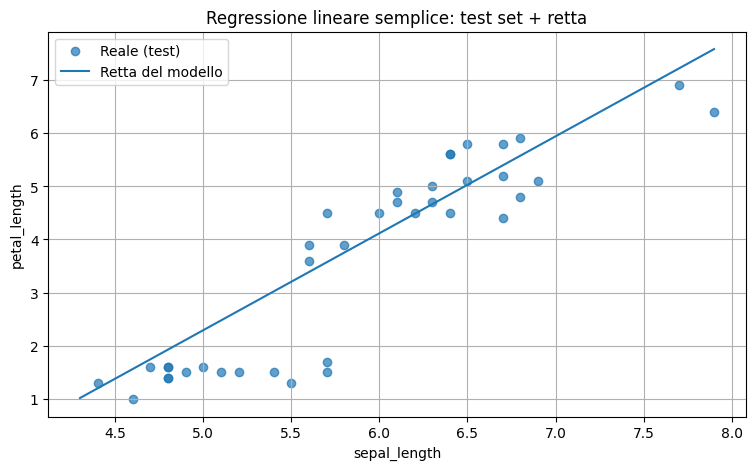

In [18]:
# NOTE DIDATTICA
# Grafico: punti reali (test) e retta del modello.
# Serve a visualizzare se la retta segue la tendenza dei dati.

# Scatter dei dati
plt.scatter(X_test[x_col], y_test, label="Reale (test)", alpha=0.7)

# Linea della regressione: prendiamo un range di x e calcoliamo y_hat
x_line = np.linspace(df[x_col].min(), df[x_col].max(), 100)
y_line = model.predict(pd.DataFrame({x_col: x_line}))

plt.plot(x_line, y_line, label="Retta del modello")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Regressione lineare semplice: test set + retta")
plt.legend()
plt.show()

### 5.5 Grafico: reale vs predetto

Se fosse perfetto, i punti starebbero sulla diagonale.

Grafico diagnostico molto utile:

- asse X: valore reale
- asse Y: valore predetto

Se il modello fosse perfetto, tutti i punti starebbero sulla diagonale y = x.
La distanza dalla diagonale misura l'errore.


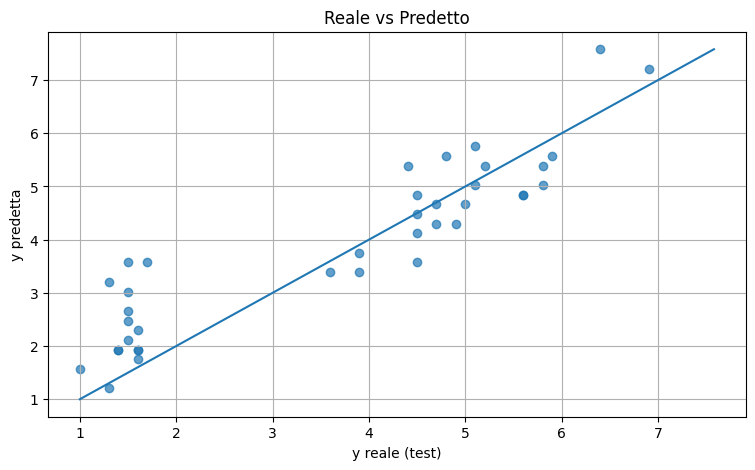

In [19]:
# NOTE DIDATTICA
# Grafico reale vs predetto: se il modello fosse perfetto, i punti starebbero su y=x.

plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)
plt.xlabel("y reale (test)")
plt.ylabel("y predetta")
plt.title("Reale vs Predetto")
plt.show()

### 5.6 Residui (errori) e cosa ci dicono

Residuo = `y_reale - y_predetta`.

Un buon modello ha residui:
- centrati attorno a 0
- senza pattern evidenti quando li mettiamo contro `x`

Il residuo e':

- **residuo = y_reale - y_predetto**

Analizzare i residui e' importante perche' ci dice *come* il modello sbaglia.

Cosa vogliamo vedere (in un mondo ideale):
- residui distribuiti attorno a 0
- nessun pattern evidente

Pattern tipici:
- residui che crescono con x: il modello lineare non basta (forse relazione curva)
- residui molto asimmetrici: outlier o dati non omogenei


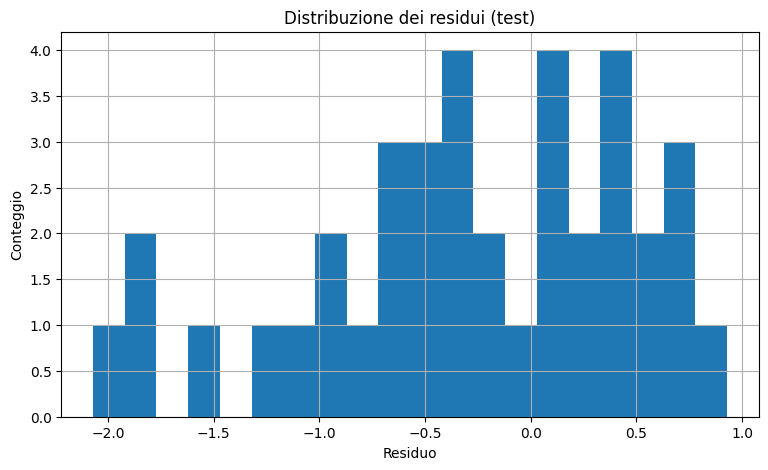

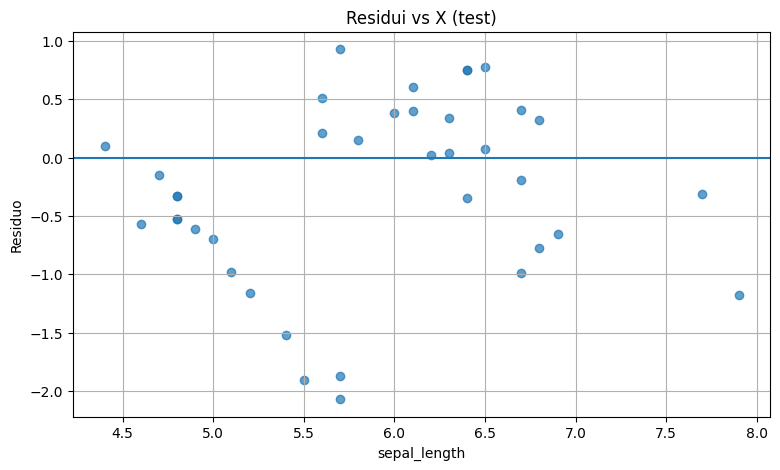

In [20]:
# NOTE DIDATTICA
# Residui = reale - predetto.
# Se vedi pattern nei residui, spesso la relazione non e' ben modellata da una retta.

residuals = y_test - y_pred

plt.hist(residuals, bins=20)
plt.title("Distribuzione dei residui (test)")
plt.xlabel("Residuo")
plt.ylabel("Conteggio")
plt.show()

plt.scatter(X_test[x_col], residuals, alpha=0.7)
plt.axhline(0)
plt.title("Residui vs X (test)")
plt.xlabel(x_col)
plt.ylabel("Residuo")
plt.show()

## 6) Mini-esercizio (10–15 min)

1. Cambia `x_col` con un’altra colonna numerica (es. `sepal_width`).
2. Riesegui le celle dalla sezione 4.2 in poi.
3. Confronta MAE / RMSE / R² e i grafici.

Domanda: **qual è la migliore singola variabile per prevedere `petal_length`?**

Suggerimento: prova 2–3 opzioni, non tutte.

Esercizio guidato per fissare i concetti:

1) Cambia `x_col` e/o `y_col` (scegli altre colonne numeriche)
2) Riesegui le sezioni 5.1–5.6
3) Confronta:
   - scatter (relazione visiva)
   - MAE/RMSE/R^2

Domande per lo studente:
- Quale scelta di X predice meglio y?
- Perche' alcune coppie funzionano meglio?


## 7) Regressione multipla (più X → una y)

Ora usiamo più colonne come input, ad esempio:
- `sepal_length`, `sepal_width`, `petal_width`

e teniamo `y = petal_length`.

In pratica: la “retta” diventa un **piano/iperpiano**.

In [21]:
# NOTE DIDATTICA
# Regressione multipla: X ora ha piu' colonne (feature_cols).
# Stesso identico flusso: split -> fit -> predict -> metriche.

feature_cols = ["sepal_length", "sepal_width", "petal_width"]
for c in feature_cols + [y_col]:
    if c not in df.columns:
        raise ValueError(f"Manca la colonna {c}. Colonne disponibili: {list(df.columns)}")

X2 = df[feature_cols].copy()
y2 = df[y_col].copy()

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42
)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)

y2_pred = model2.predict(X2_test)

mae2 = mean_absolute_error(y2_test, y2_pred)
rmse2 = mean_squared_error(y2_test, y2_pred) ** 0.5
r2_2 = r2_score(y2_test, y2_pred)

print("Metriche regressione multipla")
print(f"MAE  = {mae2:.3f}")
print(f"RMSE = {rmse2:.3f}")
print(f"R²   = {r2_2:.3f}")


Metriche regressione multipla
MAE  = 0.246
RMSE = 0.341
R²   = 0.966


### 7.1 Coefficienti: “quanto pesa” ogni variabile

Attenzione: senza normalizzare le feature, i coefficienti dipendono dalle scale.
Qui le scale sono simili, quindi è comunque leggibile per una lezione junior.

Nella regressione multipla, ogni coefficiente ha questo significato:

- a_i = quanto cambia y se x_i aumenta di 1 **tenendo fisse** le altre variabili

Attenzione: se le feature hanno scale diverse, i coefficienti possono sembrare non confrontabili.
(qui lo scopo e' capire il concetto, non fare feature engineering avanzato).


,feature,coef
2,petal_width,1.462903
0,sepal_length,0.737151
1,sepal_width,-0.647337


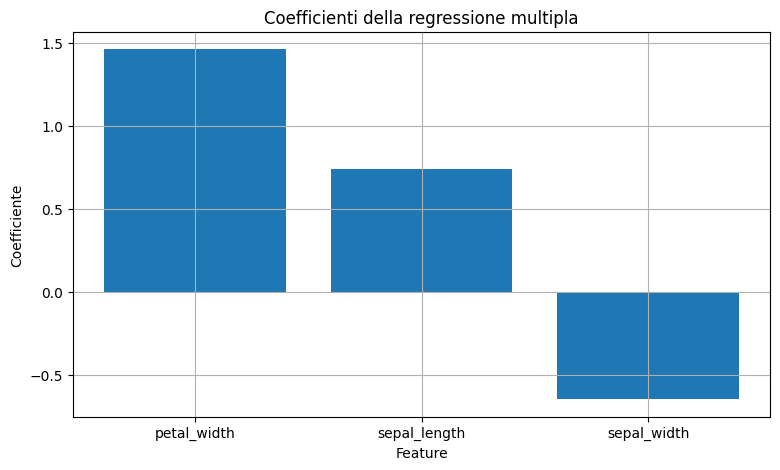

In [22]:
# NOTE DIDATTICA
# Tabella coefficienti: indica il peso di ogni feature (tenendo fisse le altre).

coef_table = pd.DataFrame({
    "feature": feature_cols,
    "coef": model2.coef_
}).sort_values("coef", ascending=False)

display(coef_table)

plt.bar(coef_table["feature"], coef_table["coef"])
plt.title("Coefficienti della regressione multipla")
plt.xlabel("Feature")
plt.ylabel("Coefficiente")
plt.show()

### 7.2 Grafico: reale vs predetto (multipla)

Stesso grafico diagnostico di prima, ma ora il modello usa piu' feature.

Se i punti sono piu' vicini alla diagonale rispetto al modello semplice, il modello multiplo sta migliorando.


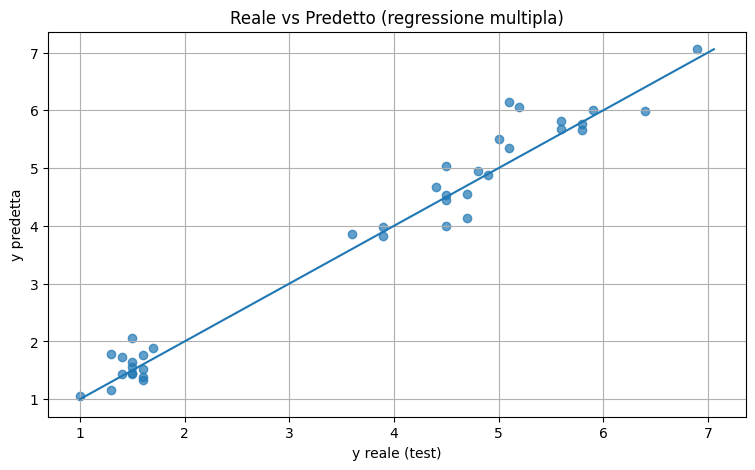

In [23]:
# NOTE DIDATTICA
# Reale vs predetto anche per il modello multiplo (stesso grafico diagnostico).

plt.scatter(y2_test, y2_pred, alpha=0.7)
lims = [min(y2_test.min(), y2_pred.min()), max(y2_test.max(), y2_pred.max())]
plt.plot(lims, lims)
plt.xlabel("y reale (test)")
plt.ylabel("y predetta")
plt.title("Reale vs Predetto (regressione multipla)")
plt.show()

## 8) Confronto semplice: modello 1 vs modello 2

Quale generalizza meglio?

Ricorda: un modello con più feature *può* migliorare, ma non è garantito.

Qui mettiamo a confronto i modelli in modo pratico.

Regola: confronta modelli solo se:
- usano lo stesso target y
- sono valutati su uno split comparabile

Cosa osservare:
- MAE/RMSE piu' bassi = meglio
- R^2 piu' alto = meglio

Ma attenzione: un modello piu' complesso non e' sempre meglio. Se migliora poco, potrebbe non valere la pena.


In [24]:
# NOTE DIDATTICA
# Confronto finale: mettiamo le metriche in tabella per vedere quale modello funziona meglio.

comparison = pd.DataFrame([
    {"modello": "Semplice (sepal_length -> petal_length)", "MAE": mae, "RMSE": rmse, "R2": r2},
    {"modello": "Multipla (3 feature -> petal_length)", "MAE": mae2, "RMSE": rmse2, "R2": r2_2},
])
comparison

,modello,MAE,RMSE,R2
0,Semplice (sepal_length -> petal_length),0.643925,0.822117,0.800910
1,Multipla (3 feature -> petal_length),0.246409,0.340505,0.965847


## 9) Estensione opzionale: regressione polinomiale (sezione “wow”)

Se gli studenti sono molto junior, questa parte può essere solo dimostrativa.

Idea: aggiungiamo `x²` per permettere una curva.

Useremo **solo numpy** (senza pipeline) per restare leggibili.

La regressione lineare puo' fallire se la relazione tra x e y e' curva.

Idea semplice (senza modelli nuovi):
- aggiungiamo una nuova feature che e' **x^2**

Poi usiamo sempre `LinearRegression`, ma su due feature (x e x^2).

Risultato: il modello puo' rappresentare una curva (parabola).


In [25]:
# NOTE DIDATTICA
# Regressione polinomiale: aggiungiamo una feature x^2 e usiamo sempre LinearRegression.
# Questo permette di modellare una curva (parabola) invece di una semplice retta.

# Regressione polinomiale di grado 2: y_hat = a2*x^2 + a1*x + b
X_poly = pd.DataFrame({
    x_col: df[x_col],
    f"{x_col}^2": df[x_col] ** 2
})
y_poly = df[y_col]

Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_poly, y_poly, test_size=0.25, random_state=42
)

modelp = LinearRegression()
modelp.fit(Xp_train, yp_train)

yp_pred = modelp.predict(Xp_test)

maep = mean_absolute_error(yp_test, yp_pred)
rmsep = mean_squared_error(yp_test, yp_pred) ** 0.5
r2p = r2_score(yp_test, yp_pred)

print("Metriche polinomiale (grado 2)")
print(f"MAE  = {maep:.3f}")
print(f"RMSE = {rmsep:.3f}")
print(f"R²   = {r2p:.3f}")


Metriche polinomiale (grado 2)
MAE  = 0.573
RMSE = 0.810
R²   = 0.807


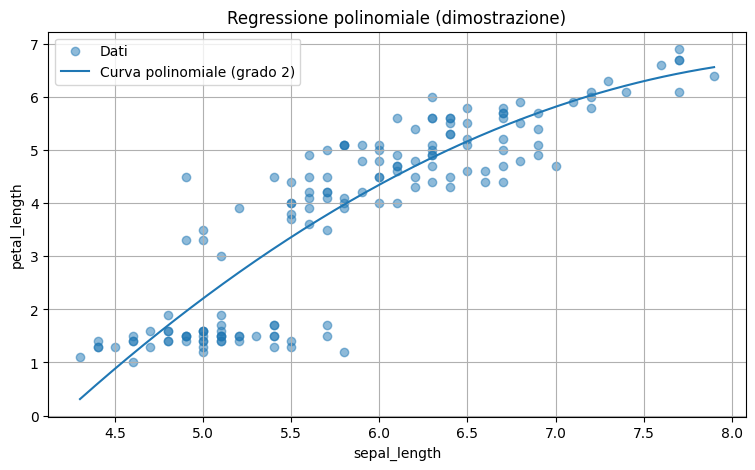

In [26]:
# NOTE DIDATTICA
# Visualizzazione della curva: creiamo una griglia di x ordinati e disegniamo la predizione polinomiale.

# Grafico: dati + curva (usiamo il modello polinomiale)
plt.scatter(df[x_col], df[y_col], alpha=0.5, label="Dati")

x_line = np.linspace(df[x_col].min(), df[x_col].max(), 200)
X_line_poly = pd.DataFrame({x_col: x_line, f"{x_col}^2": x_line**2})
y_line = modelp.predict(X_line_poly)

plt.plot(x_line, y_line, label="Curva polinomiale (grado 2)")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Regressione polinomiale (dimostrazione)")
plt.legend()
plt.show()

## 10) Esercizi finali (30–40 min)

1. Cambia la variabile target `y_col` in `petal_width` e ripeti i modelli.
2. Prova un diverso split train/test (es. `test_size=0.3`) e osserva come cambiano le metriche.
3. (Bonus) Aggiungi una feature in `feature_cols` e osserva l’impatto.

Obiettivo: collegare **scelte** (feature, target, split) a **risultati** (metriche e grafici).

Esercizi per casa/aula:

1) Prova diversi insiemi di feature nella regressione multipla e confronta le metriche.
2) Prova il polinomio su altre coppie (cambia x_col e y_col) e guarda se migliora.
3) Osserva i residui: vedi pattern? cosa suggeriscono?

Bonus: prova a cambiare `test_size` e guarda come cambiano le metriche.


## 11) Riepilogo

- La regressione lineare prova a descrivere una relazione con una formula semplice.
- La valutazione va fatta su dati non visti (test set).
- Grafici e residui aiutano a capire se il modello “ha senso”.
- Più feature possono aiutare, ma vanno valutate.

Fine.

Concetti chiave da portarsi via:

- La regressione e' una stima di y a partire da X.
- `fit` = imparare i parametri, `predict` = usare il modello.
- Train/test split serve per valutare su dati nuovi.
- MAE e RMSE misurano l'errore (RMSE penalizza di piu' gli errori grandi).
- R^2 dice quanta varianza spieghi (puo' anche essere negativo).
- I grafici (reale vs predetto, residui) servono a capire *come* sbaglia il modello.
